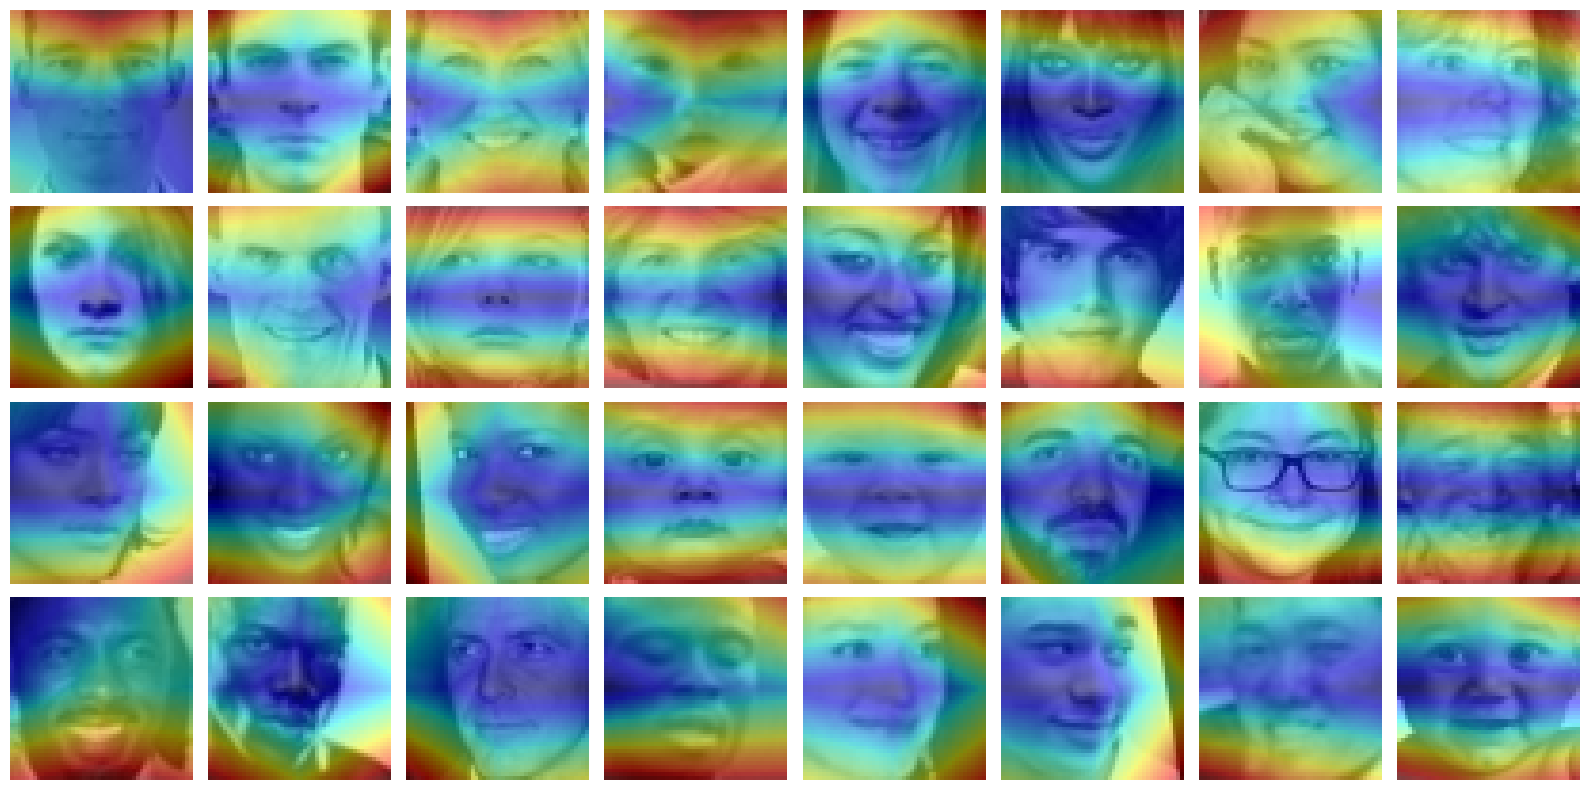

In [ ]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from huggingface_hub import hf_hub_download
from keras.api.models import load_model
from PIL import Image
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


def initialize_model(model_path: str) -> tf.keras.Model:
    """Load and return the pre-trained facial classification model."""
    return load_model(model_path)


def download_dataset(n: int = 32) -> pd.DataFrame:
    """Download and load facial image dataset from HuggingFace."""
    filepath = hf_hub_download(repo_id="rixmape/utkface", filename="data/train-00000-of-00001.parquet", repo_type="dataset")
    df = pd.read_parquet(filepath)
    return df.sample(n=n, random_state=42) if n > 0 else df


def process_row(row: pd.Series, model: tf.keras.Model) -> dict:
    """Process a single dataframe row with all pipeline steps."""
    with Image.open(BytesIO(row["image"]["bytes"])) as image:
        image = image.convert("L").resize((48, 48))
        image_array = np.array(image, dtype=np.float32) / 255.0
        image_array = np.stack([image_array] * 3, axis=-1)

    def _modifier_fn(cloned_model: tf.keras.Model) -> None:
        cloned_model.layers[-1].activation = tf.keras.activations.linear

    def _score_fn(output: tf.Tensor) -> tf.Tensor:
        return output[0][row["gender"]]

    visualizer = GradcamPlusPlus(model, model_modifier=_modifier_fn, clone=True)
    expanded_image_array = image_array if image_array.ndim == 3 else image_array[..., np.newaxis]
    activation = visualizer(_score_fn, expanded_image_array, penultimate_layer=-1)[0]

    return {"image": image_array, "activation": activation}


def display_results(results: list, rows: int = 4, cols: int = 8):
    """Display a grid of images with heatmap overlay."""
    n_images = rows * cols
    sample_indices = np.random.choice(len(results), min(n_images, len(results)), replace=False)

    _, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes_flat = axes.flatten()

    for idx, sample_idx in enumerate(sample_indices):
        if idx >= n_images:
            break

        result = results[sample_idx]
        axes_flat[idx].imshow(result["image"], cmap="gray")
        axes_flat[idx].imshow(result["activation"], cmap="jet", alpha=0.5)
        axes_flat[idx].axis("off")

    for idx in range(len(sample_indices), len(axes_flat)):
        axes_flat[idx].axis("off")

    plt.tight_layout()
    plt.show()


def run_pipeline():
    model = initialize_model("../tmp/pipeline2.keras")
    df = download_dataset()
    results = df.apply(lambda row: process_row(row, model), axis=1).tolist()
    display_results(results)


if __name__ == "__main__":
    run_pipeline()